## Full Model

In [91]:
#Import relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import numpy as np
from scipy.integrate import quad_vec
import scipy.stats as si
import pygad
import torch
from tqdm import tqdm
import random
from scipy.optimize import minimize, differential_evolution
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import UnivariateSpline


In [92]:
# Enable LaTeX fonts in plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [ ]:
# Seeds
MASTER_SEED = 42
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)


In [94]:
#Parameters

#Simulation parameters
T = 1.0                 # Time horizon (years)
N = 252                 # Number of time steps
dt = T / N              # Time increment
M = 10000                # Number of Monte Carlo simulations

#Interest rate parameters
kappa_r= 0.13                                       # Speed of mean reversion for interest rate                             # Escobar
varphi_r=0.0025                                     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
print("varphi_r/kappa_r: ", varphi_r / kappa_r)     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
sigma_r= 0.0566                                     # Volatility of the interest rate                                       # Escobar
r0 = varphi_r / kappa_r                             # Initial interest rate                                                 # Escobar

#Bond parameters
lambda_r = -0.1132                                  # Risk premium on interest rate                                         # Escobar
T_tilde = T                                         # Bond maturity

#Stock and variance 

# Parameters for Heston volatility process
kappa_v = 2.8278                                    # Speed of mean reversion for variance                                  # Escobar
varphi_v= 0.0563                                    # varphi_v/kappa_v is the long-run variance                             # Escobar
print("varphi_v/kappa_v: ", varphi_v / kappa_v)     # varphi_v/kappa_v is the long-run variance                             # Escobar
sigma_v = 0.2941                                    # Volatility of variance process                                        # Escobar
V0 = varphi_v / kappa_v                             # Initial variance                                                      # Escobar    
rho = -0.23                                         # Correlation between stock and variance shocks                         # Escobar                                  
lambda_v= -6.6932                                   # Risk premium on variance                                              # Escobar                 

# Parameters for stock price process
S0 = 100                                            # Initial stock price                                                   # Escobar
lambda_s = 2.2472                                   # Risk premium on diffusive risk                                        # Escobar                        
nu=-0.5973                                          # Factor loading stock and rate                                         # Escobar 
lambda_j = 12.3                                     # Jump intensity                                                        # Pan
lambda_j_q = lambda_j*2                             # Jump intensity Q                                                      # Liu and Pan
mu= -0.10                                           # Jump amplitude                                                        # Liu and Pan

# Parameters for jump process
lambda_J = 0.5                                      # Jump frequency                                                        # Liu and Pan

# Parameters for option pricing 
num_K= 9                                            # Number of strikes         

# General parameters
gamma= 3                                            # Risk aversion parameter                                              # Liu and Pan

varphi_r/kappa_r:  0.019230769230769232
varphi_v/kappa_v:  0.019909470259565742


In [95]:
# Function for b(T-t)
def b_func(T_tilde, t, kappa_r, lambda_r):
    xi = np.sqrt((kappa_r + lambda_r) ** 2 + 2 * sigma_r ** 2)
    exp_term = np.exp(xi * (T_tilde - t)) - 1
    num = 2 * exp_term
    den = 2 * xi + (xi + kappa_r + lambda_r) * exp_term

    if np.isnan(num) or np.isnan(den) or den == 0:
        return 0.0

    return num / den

In [96]:
print("Expected return on stock: ", r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0)
print("Expected return on bond: ", r0-lambda_r*b_func(1,0,kappa_r,lambda_r)*r0)
expected_return=r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0

Expected return on stock:  0.11921014430729271
Expected return on bond:  0.021388365884807477


In [97]:
# Allocate result arrays
call_prices = np.zeros((M, N + 1, num_K))
put_prices = np.zeros((M, N + 1, num_K))
delta_call = np.zeros((M, N + 1, num_K))
delta_put = np.zeros((M, N + 1, num_K))
vega_call = np.zeros((M, N + 1, num_K))
vega_put = np.zeros((M, N + 1, num_K))
rho_call = np.zeros((M, N + 1, num_K))
rho_put = np.zeros((M, N + 1, num_K))
jump_call = np.zeros((M, N + 1, num_K))
jump_put = np.zeros((M, N + 1, num_K))

# Paths
S_paths = np.zeros((M, N + 1))
V_paths = np.zeros((M, N + 1))
r_paths = np.zeros((M, N + 1))
N_J = np.random.poisson(lambda_J * dt, size=(M, N + 1)) 
B= np.zeros((M, N + 1))
M_t= np.zeros((M, N + 1))
dW_r = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_v = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_s = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))

sqrt_1_minus_rho2 = np.sqrt(1 - rho**2)

def simulation(S_t, V_t, r_t):
    S_paths[:, 0] = S_t
    V_paths[:, 0] = V_t
    r_paths[:, 0] = r_t
    B[:, 0] = 1
    M_t[:, 0] = 1

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        # CIR
        r_new = r_prev + (varphi_r - kappa_r * r_prev) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r[:, j]
        r_new = np.maximum(r_new, 0)

        # Heston
        V_new = V_prev + (varphi_v - kappa_v * V_prev) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock Diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v[:, j] + sqrt_1_minus_rho2 * dW_s[:, j]) * S_prev+ nu*sigma_r*np.sqrt(r_prev)*dW_r[:, j]*S_prev
        
        # Jump Term
        jump_term = S_prev * mu * (N_J[:, j]- lambda_j * V_prev * dt)
        
        # Stock Drift
        drift = (r_prev+lambda_v*rho*V_prev+lambda_s*sqrt_1_minus_rho2*V_prev+nu*lambda_r*r_prev+mu*(lambda_j-lambda_j_q)*V_prev) * S_prev * dt

        # Stock Process
        S_new = S_prev + drift + diffusion + jump_term

        # Money Market
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)


        # Bond Process
        t_curr= j *dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t*r_prev) * B[:, j - 1] * dt
        diffusion_B =  -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new

    return S_paths, V_paths, r_paths

simulation(S0, V0, r0)

def simulate_bumped_V_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon):
    V_bumped = np.maximum(V_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_bumped * dt)
    drift = (r_curr + lambda_v * rho * V_bumped + lambda_s * np.sqrt(1 - rho**2) * V_bumped +
             nu * lambda_r * r_curr + mu * (lambda_j - lambda_j_q) * V_bumped) * S_curr * dt
    diffusion = (np.sqrt(V_bumped) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_curr) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def simulate_bumped_r_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon):
    r_bumped = np.maximum(r_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_curr * dt)
    drift = (r_bumped + lambda_v * rho * V_curr + lambda_s * np.sqrt(1 - rho**2) * V_curr +
             nu * lambda_r * r_bumped + mu * (lambda_j - lambda_j_q) * V_curr) * S_curr * dt
    diffusion = (np.sqrt(V_curr) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_bumped) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def numerical_option_pricing(S, K):
    return max(S - K, 0), max(K - S, 0)

epsilon_S = 1e-4
epsilon_V = 1e-3  # for Vega
epsilon_r = 1e-3  # for Rho

for i in tqdm(range(M), desc="Simulating Monte Carlo Paths"):
    for j in range(N + 1):
        S_mean = np.mean(S_paths[:, j])
        S_curr = S_paths[i, j]
        strike_prices = np.linspace(S_mean * 0.8, S_mean * 1.2, num_K)
        S_bump_S_up = S_curr + epsilon_S
        S_bump_S_down = S_curr - epsilon_S
        S_bump_jump = S_curr * (1 + mu)

        S_bumped_V = simulate_bumped_V_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_V)
        S_bumped_r = simulate_bumped_r_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_r)

        for k, K in enumerate(strike_prices):
            call, put = numerical_option_pricing(S_curr, K)
            call_prices[i, j, k] = call
            put_prices[i, j, k] = put
            call_V, put_V = numerical_option_pricing(S_bumped_V, K)
            call_r, put_r = numerical_option_pricing(S_bumped_r, K)
            call_S_up, put_S_up = numerical_option_pricing(S_bump_S_up, K)
            call_S_down, put_S_down = numerical_option_pricing(S_bump_S_down, K)
            call_J, put_J = numerical_option_pricing(S_bump_jump, K)

            delta_call[i, j, k] = (call_S_up - call_S_down) / (epsilon_S*2)
            delta_put[i, j, k] = (put_S_up - put_S_down) / (epsilon_S*2)
            vega_call[i, j, k] = (call_V - call) / epsilon_V
            vega_put[i, j, k] = (put_V - put) / epsilon_V
            rho_call[i, j, k] = (call_r - call) / epsilon_r
            rho_put[i, j, k] = (put_r - put) / epsilon_r
            jump_call[i, j, k] = (call_J - call) 
            jump_put[i, j, k] = (put_J - put)

print("Simulation and pricing complete!")

S=S_paths
V=V_paths
r=r_paths

Simulating Monte Carlo Paths: 100%|██████████| 10000/10000 [02:54<00:00, 57.18it/s]

Simulation and pricing complete!


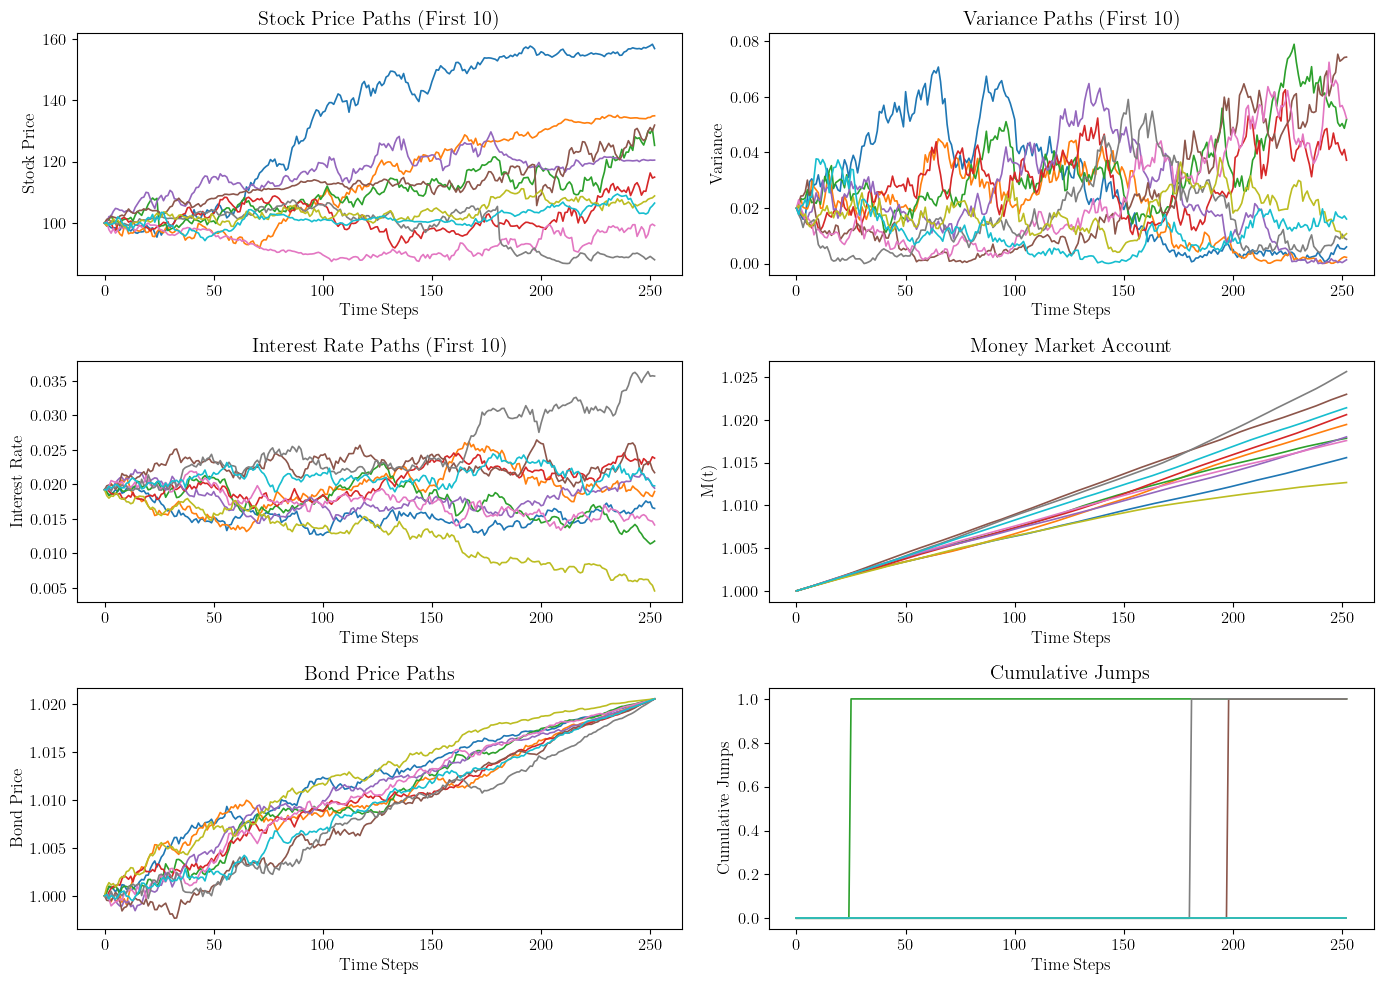

In [98]:
def plot_paths(S, V, r, M_t, B, N_J, num_paths=10):
    S = S[:num_paths]
    V = V[:num_paths]
    r = r[:num_paths]
    M_t = M_t[:num_paths]
    B = B[:num_paths]
    N_J = N_J[:num_paths]

    plt.figure(figsize=(14, 10))

    plt.subplot(3, 2, 1)
    plt.plot(S.T, linewidth=1.2)
    plt.title("Stock Price Paths (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price")

    plt.subplot(3, 2, 2)
    plt.plot(V.T, linewidth=1.2)
    plt.title("Variance Paths (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Variance")

    plt.subplot(3, 2, 3)
    plt.plot(r.T, linewidth=1.2)
    plt.title("Interest Rate Paths (First 10)")
    plt.xlabel("Time Steps")
    plt.ylabel("Interest Rate")

    plt.subplot(3, 2, 4)
    plt.plot(M_t.T, linewidth=1.2)
    plt.title("Money Market Account ")
    plt.xlabel("Time Steps")
    plt.ylabel("M(t)")

    plt.subplot(3, 2, 5)
    plt.plot(B.T, linewidth=1.2)
    plt.title("Bond Price Paths ")
    plt.xlabel("Time Steps")
    plt.ylabel("Bond Price")

    plt.subplot(3, 2, 6)
    cumulative_jumps = np.cumsum(N_J, axis=1)
    plt.plot(cumulative_jumps.T, linewidth=1.2)
    plt.title("Cumulative Jumps ")
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Jumps")

    plt.tight_layout()
    plt.show()

# Now call the plotting function with your simulation results
plot_paths(S, V, r, M_t, B, N_J, num_paths=10)


In [99]:
def compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j):
    k1_v = kappa_v - (1 - gamma) / gamma * (lambda_v* sigma_v) 
    k3_v=(lambda_v**2 + lambda_s**2) * ((1 - gamma) / (gamma))+lambda_j_q*(gamma*(lambda_j/lambda_j_q)**(1/gamma)+(1-gamma)-(lambda_j/lambda_j_q))
    k4_v=(sigma_v**2)/gamma
    k2_v = np.sqrt(k1_v**2 - k3_v*k4_v)
    return k1_v, k2_v, k3_v

def compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r):
    k1_r = kappa_r - ((1 - gamma) *(lambda_r))/ gamma 
    k3_r=2*(1-gamma)+(lambda_r**2*(1-gamma))/(gamma*sigma_r**2)
    k4_r=(sigma_r**2)/gamma
    k2_r = np.sqrt(k1_r**2 - k3_r*k4_r)
    return k1_r, k2_r, k3_r

def H_v(tau, k1_v, k2_v, k3_v):
    denominator = 2 * k2_v + (k1_v + k2_v) * (np.exp(k2_v * tau) - 1)
    H_v_star = ((np.exp(k2_v*tau)-1) / denominator)*k3_v
    return H_v_star

def H_r(tau, k1_r, k2_r, k3_r):
    denominator = 2 * k2_r + (k1_r + k2_r) * (np.exp(k2_r * tau) - 1)
    H_r_star = ((np.exp(k2_r*tau)-1) / denominator)*k3_r
    return H_r_star

def theta_cal(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q, tau):
    theta_s=lambda_s/gamma
    theta_v=lambda_v/gamma+1/gamma*sigma_v*H_v(tau, k1_v, k2_v, k3_v)
    theta_r=lambda_r/(sigma_r**2*gamma)+1/gamma*H_r(tau, k1_r, k2_r, k3_r)
    theta_N=1/mu*((lambda_j/lambda_j_q)**(1/gamma)-1)
    return theta_s, theta_v, theta_r, theta_N

def pi_calc(theta_s, theta_v, theta_r, theta_N, A1_1, A2_1, A3_1, A4_1,A1_2, A2_2, A3_2, A4_2 ,T_tilde,t,kappa_r,lambda_r, mu,rho, nu, penalty=0.1):    
    b_val = float(b_func(T_tilde, t, kappa_r, lambda_r))
    
    A = np.array([
    [np.sqrt(1 - rho**2), 0, A1_1/10, A1_2/10],
    [nu, -b_val*100, A2_1/10, A2_2/10],
    [rho, 0, A3_1/10, A3_2/10],
    [1, 0, (1/mu)*(A4_1/10), (1/mu)*(A4_2/10)]])

    theta = np.array([theta_s, theta_r, theta_v, theta_N], dtype=float)

    # Normalize A and theta
    row_norms = np.linalg.norm(A, axis=1, keepdims=True)
    A = A / row_norms
    theta = theta / row_norms.squeeze()

    try:
        pi = np.linalg.solve(A, theta)
    except np.linalg.LinAlgError:
        pi = np.linalg.pinv(A) @ theta

    pi_s = pi[0]
    pi_b = pi[1]
    pi_o1 = pi[2]
    pi_o2 = pi[3]
    pi_mm = 1 - pi_s - pi_b - pi_o1 - pi_o2

    return pi_s, pi_b, pi_o1, pi_o2, pi_mm


In [102]:
def compute_A_O_single_k(call_idx, put_idx,
                         A1_1, A2_1, A3_1, A4_1,
                         A1_2, A2_2, A3_2, A4_2,
                         O_1, O_2,
                         delta_call, rho_call, vega_call, jump_sensitivity_call,
                         delta_put, rho_put, vega_put, jump_sensitivity_put,
                         S, V, r, dW_s, dW_v, dW_r, N_J,
                         rho, nu, sigma_v, lambda_s, lambda_r, lambda_v,
                         lambda_j, lambda_j_q, sigma_r, dt, N):
    
    eps = 0.5  # Ensure not divide by zero

    for t in range(1, N + 1):

        safe_O1 = call_prices[:, t-1, call_idx]+eps
        safe_O2 = put_prices[:, t-1, put_idx]+eps

        A1_1[:, t, call_idx] = delta_call[:, t-1, call_idx] * S[:, t-1] * np.sqrt(1 - rho**2) / safe_O1
        A2_1[:, t, call_idx] = (delta_call[:, t-1, call_idx] * S[:, t-1] * nu + rho_call[:, t-1, call_idx]) / safe_O1
        A3_1[:, t, call_idx] = (delta_call[:, t-1, call_idx] * S[:, t-1] * rho + vega_call[:, t-1, call_idx] * sigma_v) / safe_O1
        A4_1[:, t, call_idx] = jump_sensitivity_call[:, t-1, call_idx] / safe_O1

        A1_2[:, t, put_idx] = delta_put[:, t-1, put_idx] * S[:, t-1] * np.sqrt(1 - rho**2) / safe_O2
        A2_2[:, t, put_idx] = (delta_put[:, t-1, put_idx] * S[:, t-1] * nu + rho_put[:, t-1, put_idx]) / safe_O2
        A3_2[:, t, put_idx] = (delta_put[:, t-1, put_idx] * S[:, t-1] * rho + vega_put[:, t-1, put_idx] * sigma_v) / safe_O2
        A4_2[:, t, put_idx] = jump_sensitivity_put[:, t-1, put_idx] / safe_O2

        O_1[:, t, call_idx] = O_1[:, t-1, call_idx] + O_1[:, t-1, call_idx] * (
            r[:, t-1] * dt +
            A1_1[:, t, call_idx] * (lambda_s * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_s[:, t-1]) +
            A2_1[:, t, call_idx] * (lambda_r * r[:, t-1] * dt + sigma_r * np.sqrt(r[:, t-1]) * dW_r[:, t-1]) +
            A3_1[:, t, call_idx] * (lambda_v * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_v[:, t-1]) +
            A4_1[:, t, call_idx] * ((lambda_j - lambda_j_q) * V[:, t-1] * dt + N_J[:, t] - lambda_j * V[:, t-1] * dt)
        )

        O_2[:, t, put_idx] = O_2[:, t-1, put_idx] + O_2[:, t-1, put_idx] * (
            r[:, t-1] * dt +
            A1_2[:, t, put_idx] * (lambda_s * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_s[:, t-1]) +
            A2_2[:, t, put_idx] * (lambda_r * r[:, t-1] * dt + sigma_r * np.sqrt(r[:, t-1]) * dW_r[:, t-1]) +
            A3_2[:, t, put_idx] * (lambda_v * V[:, t-1] * dt + np.sqrt(V[:, t-1]) * dW_v[:, t-1]) +
            A4_2[:, t, put_idx] * ((lambda_j - lambda_j_q) * V[:, t-1] * dt + N_J[:, t] - lambda_j * V[:, t-1] * dt)
        )

    for tensor in [A1_1, A2_1, A3_1, A4_1, A1_2, A2_2, A3_2, A4_2, O_1, O_2]:
        tensor[:] = np.nan_to_num(tensor, nan=0.0, posinf=1000.0, neginf=-1000.0)


## Ambiguity Analysis

In [ ]:


# Reset parameters
gamma = 3
T=1

# Define parameter values
lambda_v_vals = [-6.6932]
lambda_j_ratios = [2]
lambda_r_vals=[-0.1132]

# Storage
data = []

lambda_s_fixed = 2.2472

# Loops mu, gamma, lambda_ratios
for lambda_r in tqdm(lambda_r_vals, desc="Processing lambda_r Scenarios"):
    
    for lambda_v in lambda_v_vals:
        for lambda_ratio in lambda_j_ratios:

            # Define jump parameters
            lambda_j=12.3
            lambda_j_q=lambda_ratio*lambda_j
            
            # Diffusive Risk Premium
            lambda_s=((expected_return-r0)-lambda_r*r0-mu*(lambda_j-lambda_j_q)*(V0)-lambda_v*rho*(V0))/(V0 *np.sqrt(1-rho**2))
        
            O0 = 1
            O_1 = np.zeros((M, N+1, num_K))
            O_2 = np.zeros((M, N+1, num_K))
            O_1[:, 0, :] = O0  
            O_2[:, 0, :] = O0 

            A1_1 = np.zeros((M, N+1, num_K))
            A2_1 = np.zeros((M, N+1, num_K))
            A3_1 = np.zeros((M, N+1, num_K))
            A4_1 = np.zeros((M, N+1, num_K))
            A1_2 = np.zeros((M, N+1, num_K))
            A2_2 = np.zeros((M, N+1, num_K))
            A3_2 = np.zeros((M, N+1, num_K))
            A4_2 = np.zeros((M, N+1, num_K))

            call_idx=4 # ATM call
            put_idx=3 # 10 pct OTM put

            compute_A_O_single_k(call_idx, put_idx,
                         A1_1, A2_1, A3_1, A4_1,
                         A1_2, A2_2, A3_2, A4_2,
                         O_1, O_2,
                         delta_call, rho_call, vega_call, jump_call,
                         delta_put, rho_put, vega_put, jump_put,
                         S, V, r, dW_s, dW_v, dW_r, N_J,
                         rho, nu, sigma_v, lambda_s, lambda_r, lambda_v,
                         lambda_j, lambda_j_q, sigma_r, dt, N)

            t_indx = int(11/12 * N)
            T_tilde = 1
            t_curr = T_tilde * 11 / 12
            tau= T_tilde - t_curr

            A1_call = np.mean(A1_1[:, int(t_indx), call_idx], axis=0)
            A1_put = np.mean(A1_2[:, int(t_indx), put_idx], axis=0)
            A2_call = np.mean(A2_1[:, int(t_indx), call_idx], axis=0)
            A2_put = np.mean(A2_2[:, int(t_indx), put_idx], axis=0)
            A3_call = np.mean(A3_1[:, int(t_indx), call_idx], axis=0)
            A3_put = np.mean(A3_2[:, int(t_indx), put_idx], axis=0)
            A4_call = np.mean(A4_1[:, int(t_indx), call_idx], axis=0)
            A4_put = np.mean(A4_2[:, int(t_indx), put_idx], axis=0)

            k1_v, k2_v, k3_v = compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j)
            k1_r, k2_r, k3_r = compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r)
            theta_s, theta_v, theta_r, theta_N = theta_cal(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q,tau)
            pi_s, pi_b, pi_o1, pi_o2, pi_mm = pi_calc(theta_s, theta_v, theta_r, theta_N, A1_call, A2_call, A3_call, A4_call, A1_put, A2_put, A3_put, A4_put, T_tilde,t_curr,kappa_r,lambda_r, mu, rho, nu)

            data.append({
                "lambda_v": lambda_v,
                "lambda_ratio": lambda_ratio,
                "lambda_r": lambda_r,
                "stock": f"{pi_s:.3f}",
                "call": f"{pi_o1:.3f}",
                "put": f"{pi_o2:.3f}",
                "bond": f"{pi_b:.3f}",
                "money_market": f"{pi_mm:.3f}", 
            })

            

Processing lambda_r Scenarios: 100%|██████████| 1/1 [06:58<00:00, 418.78s/it]


In [108]:
#We print the results
df_results = pd.DataFrame(data)
df_results

,lambda_v,lambda_ratio,lambda_r,stock,call,put,bond,money_market
0,-6.6932,2,-0.1132,5.651,-4.445,0.513,0.536,-1.255


In [107]:
# Compute diversification metrics
def diversification_metrics_full(pi, asset_labels=None):
    pi_abs = np.abs(pi)
    w = pi_abs / np.sum(pi_abs)

    # HHI
    HHI = np.sum(w ** 2)

    # ENB (entropy-based)
    with np.errstate(divide='ignore', invalid='ignore'):
        entropy_terms = w * np.log(w)
        entropy_terms = np.nan_to_num(entropy_terms, nan=0.0, neginf=0.0, posinf=0.0)
    ENB = np.exp(-np.sum(entropy_terms))

    # Output
    print("\nDiversification Summary")
    if asset_labels is None:
        asset_labels = [f"Asset {i}" for i in range(len(pi))]
    for label, weight in zip(asset_labels, pi):
        print(f"{label:>15}: {weight:>8.4f}")
    print(f"\nHerfindahl-Hirschman Index (HHI): {HHI:.4f}")
    print(f"Effective Number of Bets (ENB):   {ENB:.2f}")

asset_labels = ["Stock", "Call", "Put", "Bond", "MM"]
pi_trimmed = np.array([pi_s, pi_o1, pi_o2, pi_b])

diversification_metrics_full(pi_trimmed, asset_labels)



Diversification Summary
          Stock:   5.6513
           Call:  -4.4454
            Put:   0.5130
           Bond:   0.5357

Herfindahl-Hirschman Index (HHI): 0.4206
Effective Number of Bets (ENB):   2.71


## Sensitivity Analysis

In [ ]:
# Reset parameters
gamma = 3
T=1

# Define parameter values
lambda_v_vals = [-10, -6, -2, 0, 2]
lambda_j_ratios = [1, 2, 5]
lambda_r_vals=[-0.5, -0.25, 0, 0.25]

# Storage
data = []

lambda_s_fixed = 2.2472

# Loops mu, gamma, lambda_ratios
for lambda_r in tqdm(lambda_r_vals, desc="Processing lambda_r Scenarios"):
    
    for lambda_v in lambda_v_vals:
        for lambda_ratio in lambda_j_ratios:

            # Define jump parameters
            lambda_j=12.3
            lambda_j_q=lambda_ratio*lambda_j
            
            # Diffusive Risk Premium
            lambda_s=((expected_return-r0)-lambda_r*r0-mu*(lambda_j-lambda_j_q)*(V0)-lambda_v*rho*(V0))/(V0 *np.sqrt(1-rho**2))
        
            O0 = 1
            O_1 = np.zeros((M, N+1, num_K))
            O_2 = np.zeros((M, N+1, num_K))
            O_1[:, 0, :] = O0  
            O_2[:, 0, :] = O0 

            A1_1 = np.zeros((M, N+1, num_K))
            A2_1 = np.zeros((M, N+1, num_K))
            A3_1 = np.zeros((M, N+1, num_K))
            A4_1 = np.zeros((M, N+1, num_K))
            A1_2 = np.zeros((M, N+1, num_K))
            A2_2 = np.zeros((M, N+1, num_K))
            A3_2 = np.zeros((M, N+1, num_K))
            A4_2 = np.zeros((M, N+1, num_K))

            call_idx=4 # ATM call
            put_idx=3 # 5 pct OTM put

            compute_A_O_single_k(call_idx, put_idx,
                         A1_1, A2_1, A3_1, A4_1,
                         A1_2, A2_2, A3_2, A4_2,
                         O_1, O_2,
                         delta_call, rho_call, vega_call, jump_call,
                         delta_put, rho_put, vega_put, jump_put,
                         S, V, r, dW_s, dW_v, dW_r, N_J,
                         rho, nu, sigma_v, lambda_s, lambda_r, lambda_v,
                         lambda_j, lambda_j_q, sigma_r, dt, N)

            t_indx = int(11/12 * N)
            T_tilde = 1
            t_curr = T_tilde * 11 / 12
            tau= T_tilde - t_curr

            A1_call = np.mean(A1_1[:, int(t_indx), call_idx], axis=0)
            A1_put = np.mean(A1_2[:, int(t_indx), put_idx], axis=0)
            A2_call = np.mean(A2_1[:, int(t_indx), call_idx], axis=0)
            A2_put = np.mean(A2_2[:, int(t_indx), put_idx], axis=0)
            A3_call = np.mean(A3_1[:, int(t_indx), call_idx], axis=0)
            A3_put = np.mean(A3_2[:, int(t_indx), put_idx], axis=0)
            A4_call = np.mean(A4_1[:, int(t_indx), call_idx], axis=0)
            A4_put = np.mean(A4_2[:, int(t_indx), put_idx], axis=0)

            k1_v, k2_v, k3_v = compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j)
            k1_r, k2_r, k3_r = compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r)
            theta_s, theta_v, theta_r, theta_N = theta_cal(gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r, k1_r, k2_r, k3_r,k1_v, k2_v, k3_v, mu, lambda_j, lambda_j_q,tau)
            pi_s, pi_b, pi_o1, pi_o2, pi_mm = pi_calc(theta_s, theta_v, theta_r, theta_N, A1_call, A2_call, A3_call, A4_call, A1_put, A2_put, A3_put, A4_put, T_tilde,t_curr,kappa_r,lambda_r, mu, rho, nu)

            data.append({
                "lambda_v": lambda_v,
                "lambda_ratio": lambda_ratio,
                "lambda_r": lambda_r,
                "stock": f"{pi_s:.3f}",
                "call": f"{pi_o1:.3f}",
                "put": f"{pi_o2:.3f}",
                "bond": f"{pi_b:.3f}",
                "money_market": f"{pi_mm:.3f}", 
            })

            

Processing lambda_r Scenarios: 100%|██████████| 4/4 [3:26:24<00:00, 3096.25s/it]  


In [89]:
df = pd.DataFrame(data)

# Pivot table to get 3-level MultiIndex: (asset, mu, frequency)
df_table = df.pivot_table(
    index=["lambda_v", "lambda_ratio"],
    columns=["lambda_r"],
    values=["stock", "call", "put", "bond", "money_market"],
    aggfunc="first"
)

# Move levels to: (mu, frequency, asset)
df_table.columns = df_table.columns.reorder_levels([1, 0])
df_table = df_table.sort_index(axis=1, level=[0, 1]) 

# Reorder the innermost level (assets)
desired_order = ["stock", "call", "put", "bond", "money_market"]
df_table = df_table.loc[:, sorted(df_table.columns, key=lambda x: (x[0], desired_order.index(x[1])))]

# Format and style the table
df_table_style = df_table.style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).set_caption("Table 1: Optimal strategies")

df_table_style


In [ ]:
# Latex code

def print_latex_blocks(df_table, split_left=[-0.5, -0.25], split_right=[0.0, 0.25]):
    import pandas as pd

    def print_block(df_block, label):
        print(f"\n% === {label} ===")
        df_flat = df_block.copy()
        df_flat.columns = [f"{lamr:.3f} {var}" for (lamr, var) in df_flat.columns]
        df_flat = df_flat.round(3)

        last_lambda_v = None
        unique_ratios = df_flat.index.get_level_values("lambda_ratio").unique()

        for (lambda_v, lambda_ratio), row in df_flat.iterrows():
            lambda_v_str = f"\\multirow{{3}}{{*}}{{{lambda_v}}}" if lambda_v != last_lambda_v else "    "
            last_lambda_v = lambda_v

            values = [f"{float(val):.3f}" if pd.notnull(val) else "--" for val in row.values]
            line = f"{lambda_v_str} & {lambda_ratio} & " + " & ".join(values) + r" \\"
            print(line)

            if lambda_ratio == unique_ratios[-1]:
                print(r"\hline")

    left_cols = [col for col in df_table.columns if col[0] in split_left]
    right_cols = [col for col in df_table.columns if col[0] in split_right]

    df_left = df_table[left_cols]
    df_right = df_table[right_cols]

    print_block(df_left, "Block 1: λ_r = -0.5 and -0.25")
    print_block(df_right, "Block 2: λ_r = 0.0 and 0.25")

print_latex_blocks(df_table)



% === Block 1: λ_r = -0.5 and -0.25 ===
\multirow{3}{*}{-10} & 1 & 11.540 & -8.734 & 2.148 & 4.916 & -8.870 & 11.414 & -8.718 & 2.117 & 1.796 & -5.609 \\
     & 2 & 8.914 & -7.412 & 1.076 & 4.899 & -6.476 & 8.793 & -7.400 & 1.046 & 1.778 & -3.216 \\
     & 5 & 5.373 & -6.252 & -0.250 & 4.826 & -2.697 & 5.265 & -6.252 & -0.277 & 1.703 & 0.561 \\
\hline
\multirow{3}{*}{-6} & 1 & 7.864 & -5.205 & 1.530 & 5.475 & -8.665 & 7.735 & -5.187 & 1.499 & 2.362 & -5.409 \\
     & 2 & 5.222 & -3.869 & 0.456 & 5.460 & -6.268 & 5.097 & -3.855 & 0.425 & 2.345 & -3.013 \\
     & 5 & 1.622 & -2.659 & -0.880 & 5.396 & -2.478 & 1.511 & -2.656 & -0.908 & 2.279 & 0.774 \\
\hline
\multirow{3}{*}{-2} & 1 & 4.444 & -1.897 & 0.958 & 6.000 & -8.505 & 4.312 & -1.877 & 0.927 & 2.892 & -5.255 \\
     & 2 & 1.786 & -0.549 & -0.119 & 5.987 & -6.105 & 1.659 & -0.532 & -0.150 & 2.878 & -2.856 \\
     & 5 & -1.868 & 0.709 & -1.465 & 5.930 & -2.306 & -1.982 & 0.715 & -1.493 & 2.819 & 0.942 \\
\hline
\multirow{3}{*}{0} & 

In [ ]:
results_by_strategy = {}

# Base values for parameters
gamma_base = 3
lambda_r=-0.1132
lambda_v=-6.6932
lambda_s=2.2472
lambda_j=12.3
lambda_j_q=2*lambda_j    

T_base=1

# Time setup
T_tilde = T_base
t_curr = T_tilde * 11 / 12
tau = T_tilde - t_curr
t_indx = int(t_curr / T_tilde * N)

# Define parameters
param_sweep = {
    "gamma": np.linspace(0.5, 10, 100)
}

# Scenarios
strangle_scenarios = [
    ("Call ATM, Put ATM", 4, 4),
    ("Call ATM, Put 10 pct. OTM", 4, 2),
    ("Call ATM, Put 20 pct. OTM", 4, 0)
]

# Loop over strategy
for strategy_title, call_idx, put_idx in strangle_scenarios:

    for i, (param_name, param_vals) in enumerate(param_sweep.items()):
        pi_s_vals, pi_b_vals = [], []
        pi_o1_vals, pi_o2_vals, pi_mm_vals = [], [], []

        for val in tqdm(param_vals, desc=f"{param_name} | {strategy_title}", ncols=100):
            gamma = gamma_base if param_name != "gamma" else val

            O0 = 1
            O_1 = np.zeros((M, N+1, num_K))
            O_2 = np.zeros((M, N+1, num_K))
            O_1[:, 0, :] = O0  
            O_2[:, 0, :] = O0  

            A1_1 = np.zeros((M, N+1, num_K))
            A2_1 = np.zeros((M, N+1, num_K))
            A3_1 = np.zeros((M, N+1, num_K))
            A4_1 = np.zeros((M, N+1, num_K))
            A1_2 = np.zeros((M, N+1, num_K))
            A2_2 = np.zeros((M, N+1, num_K))
            A3_2 = np.zeros((M, N+1, num_K))
            A4_2 = np.zeros((M, N+1, num_K))

            compute_A_O_single_k(call_idx, put_idx,
                                    A1_1, A2_1, A3_1, A4_1,
                                    A1_2, A2_2, A3_2, A4_2,
                                    O_1, O_2,
                                    delta_call, rho_call, vega_call, jump_call,
                                    delta_put, rho_put, vega_put, jump_put,
                                    S, V, r, dW_s, dW_v, dW_r, N_J,
                                    rho, nu, sigma_v, lambda_s, lambda_r, lambda_v,
                                    lambda_j, lambda_j_q, sigma_r, dt, N)
            
            
            A1_call = np.mean(A1_1[:, t_indx, call_idx], axis=0)
            A1_put = np.mean(A1_2[:, t_indx, put_idx], axis=0)
            A2_call = np.mean(A2_1[:, t_indx, call_idx], axis=0)
            A2_put = np.mean(A2_2[:, t_indx, put_idx], axis=0)
            A3_call = np.mean(A3_1[:, t_indx, call_idx], axis=0)
            A3_put = np.mean(A3_2[:, t_indx, put_idx], axis=0)
            A4_call = np.mean(A4_1[:, t_indx, call_idx], axis=0)
            A4_put = np.mean(A4_2[:, t_indx, put_idx], axis=0)

            k1_v, k2_v, k3_v = compute_k1_k2_k3_vol(gamma, lambda_v, lambda_s, sigma_v, kappa_v, lambda_j_q, lambda_j)
            k1_r, k2_r, k3_r = compute_k1_k2_k3_rate(gamma, lambda_r, sigma_r, kappa_r)

            theta_s, theta_v, theta_r, theta_N = theta_cal(
                gamma, lambda_s, lambda_v, lambda_r, sigma_v, sigma_r,
                k1_r, k2_r, k3_r, k1_v, k2_v, k3_v,
                mu, lambda_j, lambda_j_q, tau
            )

            pi_s, pi_b, pi_o1, pi_o2, pi_mm = pi_calc(
                theta_s, theta_v, theta_r, theta_N,
                A1_call, A2_call, A3_call, A4_call,
                A1_put, A2_put, A3_put, A4_put,
                T_tilde, t_curr,
                kappa_r, lambda_r, mu, rho, nu
            )

            # Store
            pi_s_vals.append(pi_s)
            pi_b_vals.append(pi_b)
            pi_o1_vals.append(pi_o1)
            pi_o2_vals.append(pi_o2)
            pi_mm_vals.append(pi_mm)

        # Store by param + strategy
        if param_name not in results_by_strategy:
            results_by_strategy[param_name] = {}
        results_by_strategy[param_name][strategy_title] = {
            "x_vals": param_vals,
            "pi_s": np.array(pi_s_vals),
            "pi_b": np.array(pi_b_vals),
            "pi_o1": np.array(pi_o1_vals),
            "pi_o2": np.array(pi_o2_vals),
            "pi_mm": np.array(pi_mm_vals)
        }

gamma | Call ATM, Put ATM: 100%|██████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]
gamma | Call ATM, Put 10 pct. OTM: 100%|██████████████████████████| 100/100 [00:13<00:00,  7.56it/s]
gamma | Call ATM, Put 20 pct. OTM: 100%|██████████████████████████| 100/100 [00:13<00:00,  7.49it/s]


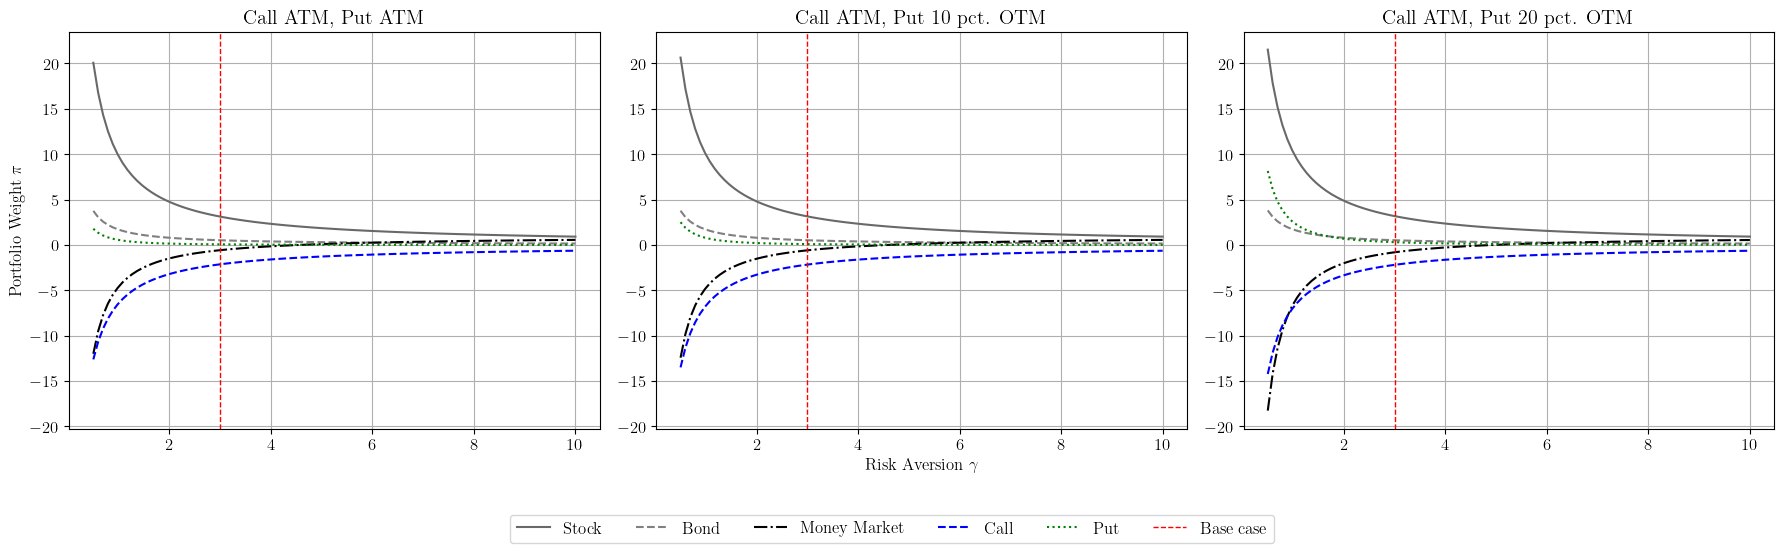

In [ ]:
# Line styles for plotting
style_dict = {
    "pi_s": {"color": "dimgray", "linestyle": "-"},
    "pi_b": {"color": "gray", "linestyle": "--"},
    "pi_o1": {"color": "blue", "linestyle": "--"},
    "pi_o2": {"color": "green", "linestyle": ":"},  # FIXED from "- -" to ":"
    "pi_mm": {"color": "black", "linestyle": "-."}
}

# Base values
base_vals = {
    "gamma": gamma_base
}

# X-axis labels
x_axis_labels = {
    "gamma": "Risk Aversion $\\gamma$"
}

# Plot a single panel
def plot_panel(ax, x, s, b, o1, o2, mm, title, base_val, x_label):
    ax.plot(x, s, label='Stock', **style_dict["pi_s"])
    ax.plot(x, b, label='Bond', **style_dict["pi_b"])
    ax.plot(x, mm, label='Money Market', **style_dict["pi_mm"])
    ax.plot(x, o1, label='Call', **style_dict["pi_o1"])
    ax.plot(x, o2, label='Put', **style_dict["pi_o2"])
    ax.axvline(x=base_val, color='red', linestyle='--', linewidth=1, label='Base case')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Portfolio Weight $\\pi$")
    ax.grid(True)

# Plot strategies
def plot_param_grid(param_name):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.subplots_adjust(wspace=0.3)

    # First, find global y-axis limits across all strategies
    y_min, y_max = float('inf'), float('-inf')
    for strategy_title, data in results_by_strategy[param_name].items():
        for key in ["pi_s", "pi_b", "pi_mm", "pi_o1", "pi_o2"]:
            y_min = min(y_min, min(data[key]))
            y_max = max(y_max, max(data[key]))
    
    padding = 0.05 * (y_max - y_min)
    y_min -= padding
    y_max += padding

    for i, strategy_title in enumerate(results_by_strategy[param_name].keys()):
        data = results_by_strategy[param_name][strategy_title]
        ax = axs[i]
        plot_panel(
            ax,
            data["x_vals"],
            data["pi_s"],
            data["pi_b"],
            data["pi_o1"],
            data["pi_o2"],
            data["pi_mm"],
            strategy_title,
            base_val=base_vals[param_name],
            x_label=x_axis_labels[param_name]
        )
        ax.set_ylim(y_min, y_max)  

        if i != 0:
            ax.set_ylabel("")
        if i != 1:
            ax.set_xlabel("")

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=6)

    plt.tight_layout()
    plt.savefig("Gamma_full_model.png", dpi=600, bbox_inches='tight')
    plt.show()

plot_param_grid("gamma")